BERT with skorch - publications_final.csv

kód byl adaptován na základě:

https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/Hugging_Face_Finetuning.ipynb#scrollTo=e6f17a28-52e3-4f0c-8c3e-308ecc9288f3

Tietz, Marian, FAN, Thomas J., NOURI, Daniel, BOSSAN, Benjamin and skorch Developers, 2017. *skorch: A scikit-learn compatible neural network library that wraps PyTorch.* [online] July 2017. Available at: https://skorch.readthedocs.io/en/stable/ [Accessed 15 March 2024]

In [ ]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 4.3 MB/s eta 0:00:00


In [ ]:
# Import knihoven
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, ProgressBar
from skorch.hf import HuggingfacePretrainedTokenizer
from torch import nn
from torch.optim.lr_scheduler import LambdaLR
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
import torch
import pandas as pd

In [ ]:
# SciBERT tokenizer a SciBERT model
TOKENIZER = 'allenai/scibert_scivocab_uncased'
PRETRAINED_MODEL = 'allenai/scibert_scivocab_uncased'

# Hyperparametry
OPTMIZER = torch.optim.AdamW
LR = 1e-5
MAX_EPOCHS = 5
CRITERION = nn.CrossEntropyLoss
BATCH_SIZE = 4

# zařízení - buď gpu, pokud je dostupné, nebo cpu
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## načtení datasetu -> pouze abstrakt a final_grade


In [ ]:
df = pd.read_csv('publications_final.csv', sep=';', encoding="utf-8")

In [ ]:
# Pouze sloupec abstrakt a final_grade
df = df[['abstract','final_grade']]
df.head()

,abstract,final_grade
0,Solar thermal façade concepts for building int...,2
1,Photosystem I of the moss Physcomitrella paten...,2
2,Purpose – The purpose of this paper is to exam...,3
3,The original Data Envelopment Analysis (DEA) m...,2
4,Although there are many reasons why medium vol...,4


In [ ]:
X = df['abstract']
y = df['final_grade']

In [ ]:
X.head()

0    Solar thermal façade concepts for building int...
1    Photosystem I of the moss Physcomitrella paten...
2    Purpose – The purpose of this paper is to exam...
3    The original Data Envelopment Analysis (DEA) m...
4    Although there are many reasons why medium vol...
Name: abstract, dtype: object

In [ ]:
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
X_train.count()

3208

## Training

In [ ]:
num_training_steps = MAX_EPOCHS * (len(X_train) // BATCH_SIZE + 1)

def lr_schedule(current_step):
    factor = float(num_training_steps - current_step) / float(max(1, num_training_steps))
    assert factor > 0
    return factor

In [ ]:
class BertModule(nn.Module):
    def __init__(self, name, num_labels):
        super().__init__()
        self.name = name
        self.num_labels = num_labels

        self.reset_weights()

    def reset_weights(self):
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            self.name, num_labels=self.num_labels
        )

    def forward(self, **kwargs):
        pred = self.bert(**kwargs)
        return pred.logits

In [ ]:
pipeline = Pipeline([
    ('tokenizer', HuggingfacePretrainedTokenizer(TOKENIZER)),
    ('net', NeuralNetClassifier(
        BertModule,
        module__name=PRETRAINED_MODEL,
        module__num_labels=len(set(y_train)),
        optimizer=OPTMIZER,
        lr=LR,
        max_epochs=MAX_EPOCHS,
        criterion=CRITERION,
        batch_size=BATCH_SIZE,
        iterator_train__shuffle=True,
        device=DEVICE,
        callbacks=[
            LRScheduler(LambdaLR, lr_lambda=lr_schedule, step_every='batch'),
            ProgressBar(),
        ],
    )),
])

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

In [ ]:
%time pipeline.fit(X_train, y_train)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
                                                                  

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.3295       0.4283        1.2909  150.3388


      2        1.1815       0.4564        1.2301  150.4085


      3        1.0005       0.4502        1.3092  149.8571


      4        0.7285       0.4361        1.4740  150.1597


      5        0.4824       0.4408        1.6198  150.3487


CPU times: user 12min 19s, sys: 3.58 s, total: 12min 22s
Wall time: 12min 34s


Pipeline(steps=[('tokenizer',
                 HuggingfacePretrainedTokenizer(tokenizer='allenai/scibert_scivocab_uncased')),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=BertModule(
    (bert): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(31090, 768, padding_idx=0)
          (position_embeddings): E...
                (dense): Linear(in_features=3072, out_features=768, bias=True)
                (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
          )
        )
        (pooler): BertPooler(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (activation): Tanh()
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (classifier): Linear(in_features=768, out_features=6, bias=True)
    )
  ),
))])

In [ ]:
%%time
with torch.inference_mode():
    y_pred = pipeline.predict(X_test)

CPU times: user 12.5 s, sys: 56.8 ms, total: 12.6 s
Wall time: 13.9 s


In [ ]:
accuracy_score(y_test, y_pred)

0.43088418430884184

In [ ]:
%%time
with torch.inference_mode():
  y_pred_proba = pipeline.predict_proba(X_test)

CPU times: user 11.8 s, sys: 30.5 ms, total: 11.9 s
Wall time: 14.3 s


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.41      0.19      0.26       134
           2       0.44      0.64      0.52       322
           3       0.44      0.42      0.43       264
           4       0.33      0.07      0.12        56
           5       0.00      0.00      0.00        10

    accuracy                           0.43       803
   macro avg       0.27      0.22      0.22       803
weighted avg       0.41      0.43      0.40       803

počet dat v testovacím datasetu: 803


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(70.72222222222221, 0.5, 'Skutečná hodnota')

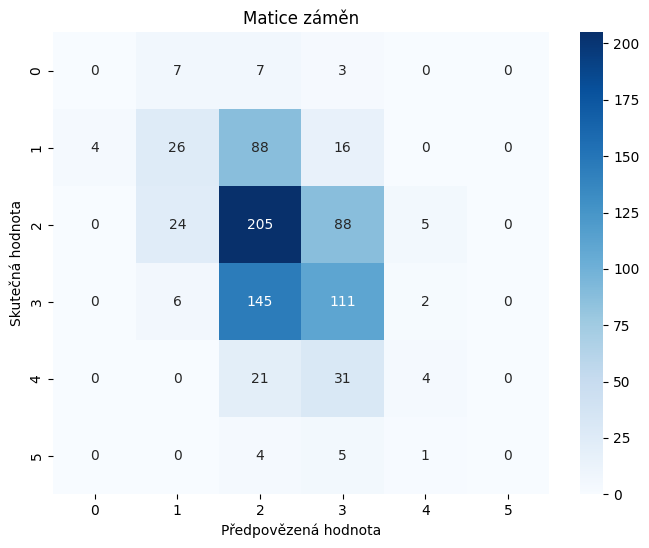

In [ ]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

n = y_test.count()
print(f"počet dat v testovacím datasetu: {n}")
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt="d")
ax.set_title("Matice záměn")
ax.set_xlabel('Předpovězená hodnota')
ax.set_ylabel('Skutečná hodnota')